## Does it really rain a lot in Seattle?

Author: Joshua Goldberg

date: 2020-04-26

When people speak about places to live and visit, a few things come to mind almost immediately: culture, food, and __weather__. Seattle might as well be a synonym for rain. While I was looking to relocate to Seattle, my friends almost universally responded "it rains a lot there." I have spent several years and Chicago. Chicago has its grey, rainy days, so I was not deterred by these comments. While I won't be comparing Chicago to Seattle, this post will generally explore the rain patterns of Seattle to find out if the anecdotes are true.

Three questions come to mind as it pertains to weather in Seattle:

- What frequency does it rain?
- How much actual rainfall occurs (measured in percipitation/inches)?
- Are there seasonal trends of rain?

While I won't include national data in this exploration, I will try to compare Seattle results to national averages.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
import seaborn as sns
%matplotlib inline

In [2]:
weather_df = pd.read_csv("seattleWeather_1948-2017.csv", parse_dates=True, squeeze=True)
weather_df.columns = map(str.lower, weather_df.columns)

The [data](https://www.kaggle.com/rtatman/did-it-rain-in-seattle-19482017) we will use for this analysis is a time series from 1948-2017 with the following:

- `date`: date associated with weather metrics
- `prcp`: percipitation in inches
- `tmax`: max temperature (Fahrenheit)
- `tmin`: minimum temperature (Fahrenheit)
- `rain`: whether it rained or not

In [3]:
weather_df.head()

,date,prcp,tmax,tmin,rain
0,1948-01-01,0.47,51,42,True
1,1948-01-02,0.59,45,36,True
2,1948-01-03,0.42,45,35,True
3,1948-01-04,0.31,45,34,True
4,1948-01-05,0.17,45,32,True


In [4]:
weather_df.dtypes

date     object
prcp    float64
tmax      int64
tmin      int64
rain     object
dtype: object

We will convert the date column to a datetime object so we can perform analysis with respect to time. Additionally, we will add some features of dates for later use.

In [23]:
weather_df['date'] = pd.to_datetime(weather_df['date'])
weather_df['day'] = [d.day for d in weather_df.date]
weather_df['month'] = [d.month for d in weather_df.date]
weather_df['year'] = [d.year for d in weather_df.date]
weather_df = weather_df[['date', 'year', 'month', 'day', 'prcp', 'tmax', 'tmin', 'rain']]
weather_df.head()

,date,year,month,day,prcp,tmax,tmin,rain
0,1948-01-01,1948,1,1,0.47,51,42,True
1,1948-01-02,1948,1,2,0.59,45,36,True
2,1948-01-03,1948,1,3,0.42,45,35,True
3,1948-01-04,1948,1,4,0.31,45,34,True
4,1948-01-05,1948,1,5,0.17,45,32,True


In [6]:
weather_df.shape

(25551, 5)

In [5]:
weather_df.describe()

,prcp,tmax,tmin
count,25548.000000,25551.000000,25551.000000
mean,0.106222,59.544206,44.514226
std,0.239031,12.772984,8.892836
min,0.000000,4.000000,0.000000
25%,0.000000,50.000000,38.000000
50%,0.000000,58.000000,45.000000
75%,0.100000,69.000000,52.000000
max,5.020000,103.000000,71.000000


Missing values do not look significant since we have 25,551 rows and only three rows are missing in the `prcp` and `rain` column. We will leave these missing values alone for now until they pose a problem.

In [14]:
weather_df[weather_df.prcp.isnull()]

,date,prcp,tmax,tmin,rain
18415,1998-06-02,NaN,72,52,NaN
18416,1998-06-03,NaN,66,51,NaN
21067,2005-09-05,NaN,70,52,NaN


Here are general time series plots of the numeric data (percipitation and temperature). It's hard to glean any insights from this high-level view, but it's good to take a quick glance in case anything jumps out.

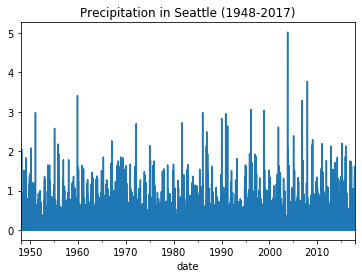

In [147]:
plot = weather_df.plot(x='date', y='prcp', legend=False)
plt.title('Precipitation in Seattle (1948-2017)')
fig = plot.get_figure()
fig.savefig('output.png')

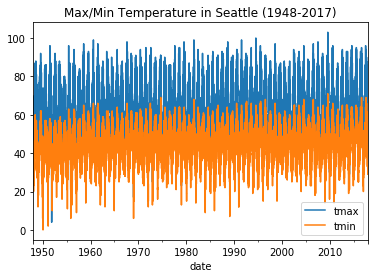

In [150]:
plot = weather_df.plot(x='date', y=['tmax', 'tmin']);
plt.title('Max/Min Temperature in Seattle (1948-2017)');
fig = plot.get_figure()
fig.savefig('output2.png')

## What frequency does it rain in Seattle?

In [24]:
proportion_df = pd.DataFrame(weather_df['rain'].value_counts() / weather_df.shape[0]).reset_index()
proportion_df = proportion_df.rename(columns={'index': 'rain', 'rain': 'proportion'})

It rained ~43% of the time in Seattle from 1948-2017.

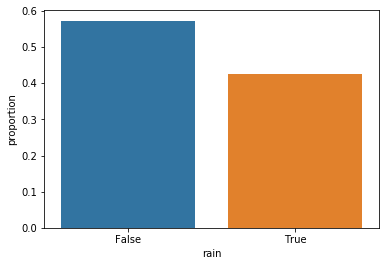

In [25]:
sns.barplot(x='rain', y='proportion', data=proportion_df);

How does this compare to the rest of the U.S.?

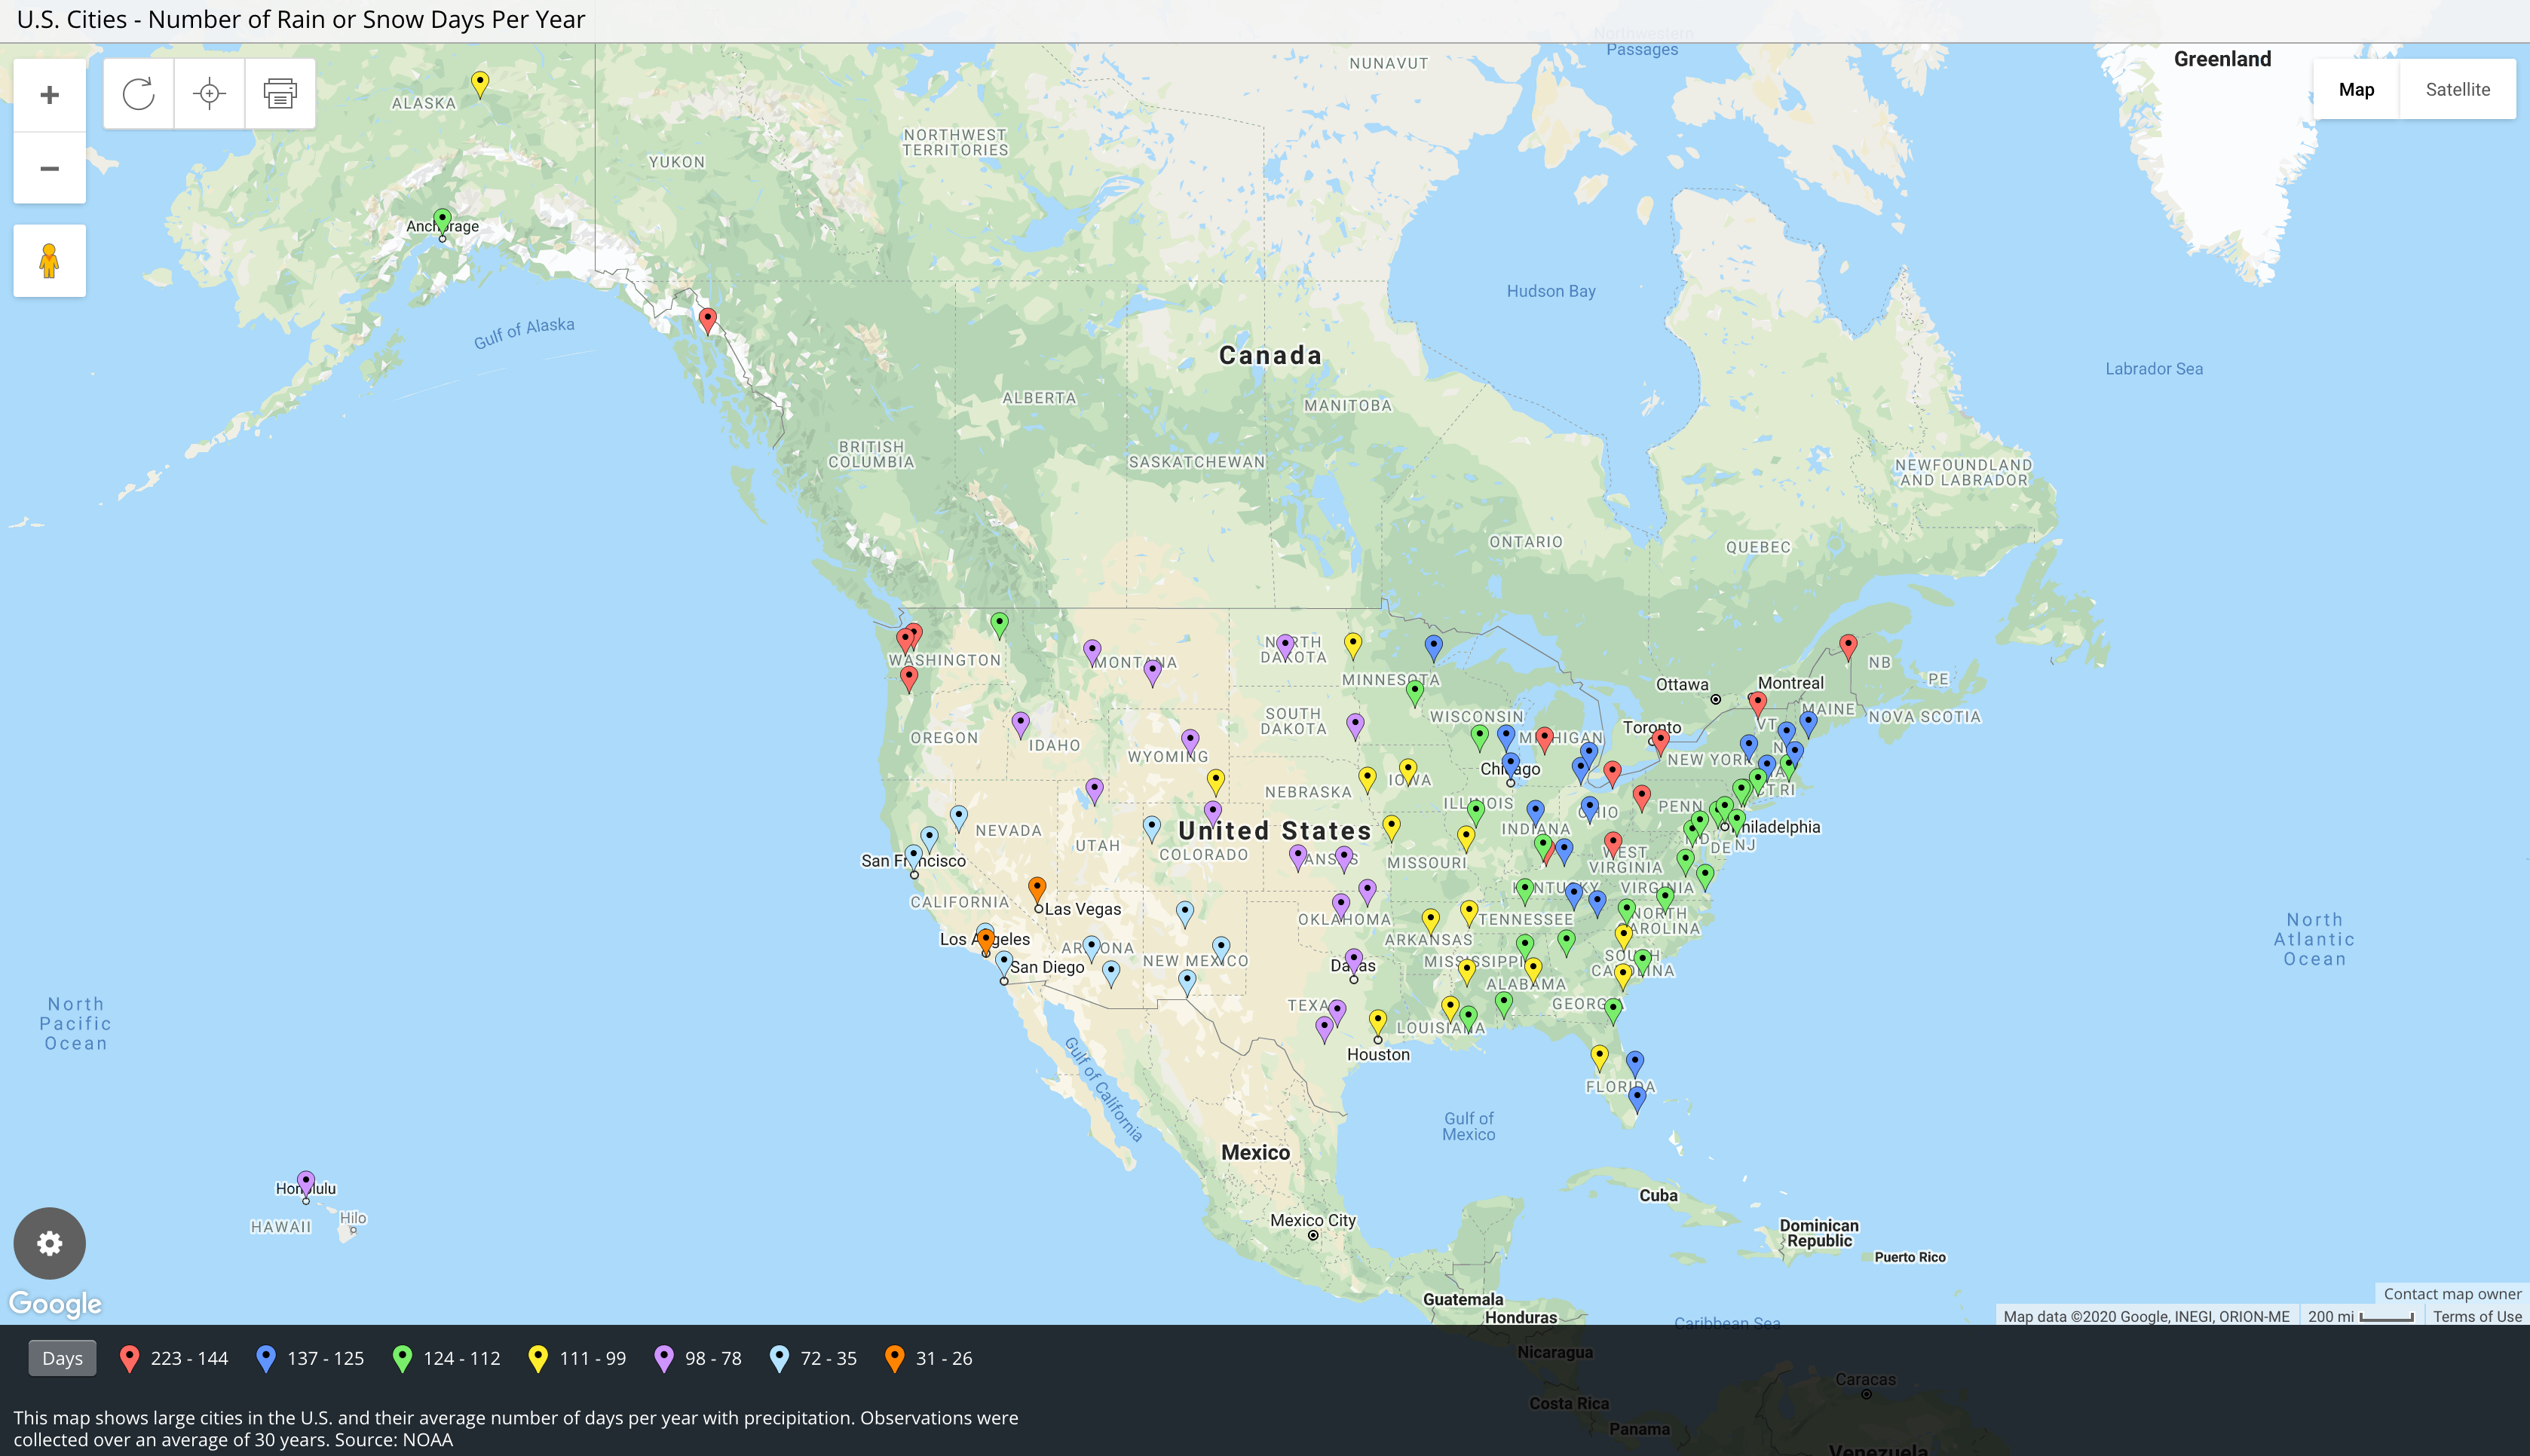

In [130]:
from IPython.display import Image
Image('national_rainfall.png')

Washington is red, indicating that the state experiences rain 144-223 days over the course of the year. Our analysis shows ~157 days of rain each year from 1948-2017. There are a few other states/areas spread about the northeast that experience similar levels to Seattle in terms of rain. Most of the states center in in between 78-137 days of rain each year.

### Frequency by year
The previous plot is represents the time series from inception to end. Looking a little deep, did the proportion of rainy days vary across time? Let's check this out over the years elapsed in the time series.

In [26]:
rain_by_year_df = weather_df[['year', 'rain']].groupby(['year', 'rain']).size().unstack(fill_value=0).reset_index()
rain_by_year_df = rain_by_year_df.assign(total=rain_by_year_df[False] + rain_by_year_df[True])
rain_by_year_df = rain_by_year_df.assign(rain_proportion = rain_by_year_df[True] / rain_by_year_df.total).drop([False, True, 'total'], axis=1)
rain_by_year_df.head()

rain,year,rain_proportion
0,1948,0.483607
1,1949,0.380822
2,1950,0.531507
3,1951,0.410959
4,1952,0.379781


At first glance, the data looks [mean-reverting](https://mathworld.wolfram.com/ReversiontotheMean.html). There is a strong decline starting in the mid 1970s that oscillates until the 1990s, but this is probably more stochastic than any kind of trend.

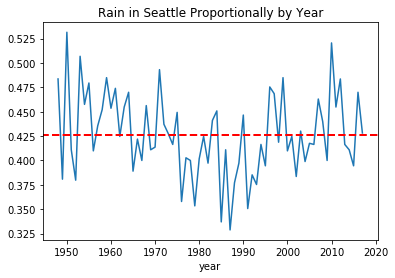

In [40]:
rain_by_year_df.set_index('year').plot(legend=False)
plt.axhline(y=proportion_df.iloc[1, :][1], xmin=-1, xmax=1, color='r', linestyle='--', lw=2)
plt.title('Rain in Seattle Proportionally by Year');

### Frequency by month

Before we look at frequency of rainy days by month, what would we expect? I have spent a lot of time in Florida and we always expect rain during the summer leading to the fall (hurricane season). Does Seattle fair the same for when rain is expected based on my experience?

In [49]:
rain_by_month_prop = weather_df[['month', 'rain']].groupby(['month', 'rain']).size().unstack(fill_value=0).reset_index()
rain_by_month_prop = rain_by_month_prop.assign(total = rain_by_month_prop[False] + rain_by_month_prop[True])
rain_by_month_prop = rain_by_month_prop.assign(rain_proportion = rain_by_month_prop[True] / rain_by_month_prop.total)
rain_by_month_prop = rain_by_month_prop.drop([True, False, 'total'], axis=1).set_index('month')

In [50]:
rain_by_month_prop

rain,rain_proportion
month,
1,0.598157
2,0.557634
3,0.558525
4,0.475238
5,0.355300
6,0.301239
7,0.158065
8,0.190323
9,0.290138


Interestinly, rainy days in the summer is not the case in Seattle. It looks like the least amount of rain days happens during the summer and fall! With the peak amount of rain days occurring during the winter and spring. Something to look further into would be the amount of rain/percipitation. It's possible that there are not as many rainy days in the summer, but when it rains Seattle may experience more rain measured by percipitation in inches.

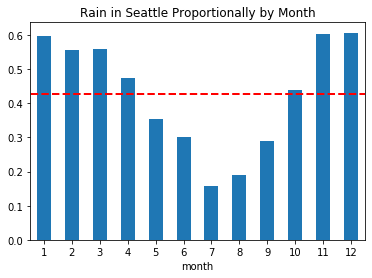

In [53]:
rain_by_month_prop.plot(kind='bar', legend=False, rot=0)
plt.axhline(y=proportion_df.iloc[1, :][1], xmin=-1, xmax=1, color='r', linestyle='--', lw=2)
plt.title('Rain in Seattle Proportionally by Month');

## How much actual rainfall occurs (measured in percipitation/inches) in Seattle?

We observed previous that rainy days (categorized as any amount of rain occuring in a day), is least likely during the summer months in Seattle. In this section, we will look further to explore the trends in actual rainfall across year and month.

In [72]:
monthly_mean = weather_df[['month', 'prcp', 'tmax', 'tmin']].groupby(['month']).mean().reset_index()
monthly_mean

,month,prcp,tmax,tmin
0,1,0.183055,45.131797,35.208756
1,2,0.143023,48.994944,36.787664
2,3,0.127963,52.321659,38.393548
3,4,0.088505,57.521905,41.460952
4,5,0.058502,64.309217,46.733180
5,6,0.048522,69.653333,51.628571
6,7,0.023106,75.497696,55.005530
7,8,0.034968,75.233180,55.317512
8,9,0.059057,69.631905,51.754286
9,10,0.119350,59.452535,45.667281


We see a similar U-shape in mean precipitation compared to the proportion of days rained plot. In other words, more actual rain fall occurs in spring and winter with the least amount of rainfall occurring in the summer. Let's see if temperature provides any explanatory power to precipitation.

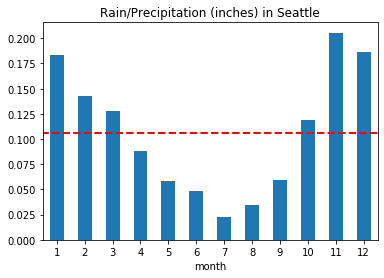

In [70]:
monthly_mean.set_index('month')[['prcp']].plot(kind='bar', rot=0, legend=False);
plt.axhline(y=monthly_mean.prcp.mean(), xmin=-1, xmax=1, color='r', linestyle='--', lw=2);
plt.title('Rain/Precipitation (inches) by Month in Seattle');

Higher temperatures in the summer (obviously) coincide with less rain. This is not too interesting, given its temperature trend is obvious. However, we can look to see if the range between high/low temperature provides more information.

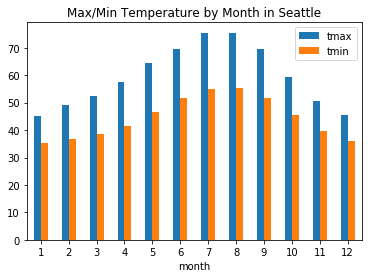

In [112]:
monthly_mean.set_index('month')[['tmax', 'tmin']].plot(kind='bar', rot=0);
plt.title('Max/Min Temperature by Month in Seattle');

In [116]:
temp_ranges = monthly_mean.tmax - monthly_mean.tmin

Winter in seattle experiences the most stable period of temperatures, while summer has a wide gap between high/low temperatures.

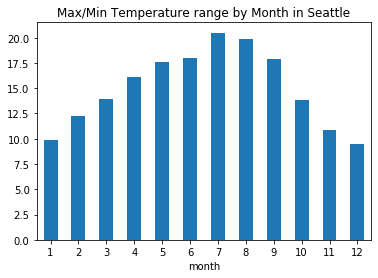

In [127]:
monthly_mean[['month', 'tmax', 'tmin']].assign(max_min_gap = temp_ranges).set_index('month')['max_min_gap'].plot(kind='bar', rot=0);
plt.title('Max/Min Temperature range by Month in Seattle');

## Are there seasonal trends of rain in Seattle?

We have actually answered this question with the previous visualizations. Rain is persistent in the spring and winter months, while the summer appears to experience the least amount of rain. A quick [interest search](https://cliffmass.blogspot.com/2015/02/why-is-northwest-warm-and-california.html) reveals that Seattle summers are warm and dry for specific meteorological reasons.

## What can we conclude?

Generally speaking, Seattle experiences a high number of 'rainy' days compared to the rest of the country. However, if we look at actual rainfall, [Seattle ranks](http://www.usa.com/rank/us--average-precipitation--state-rank.htm) in the middle of the pack.

Additionally, it's useful to know that the summers are dry and warm (rather than extremely hot). Seattle summers are [rumored](https://www.thrillist.com/entertainment/seattle/17-reasons-seattle-summers-dominate-all-other-summers) to be a blast––probably driven by the mild summer weather. Lastly, Seattle winters look predictable (temperature wise) as the high/low temperature range is narrow. So while you may see many more days of rain in the winter, you can expect to wear similar layers to fend off any chilly air.